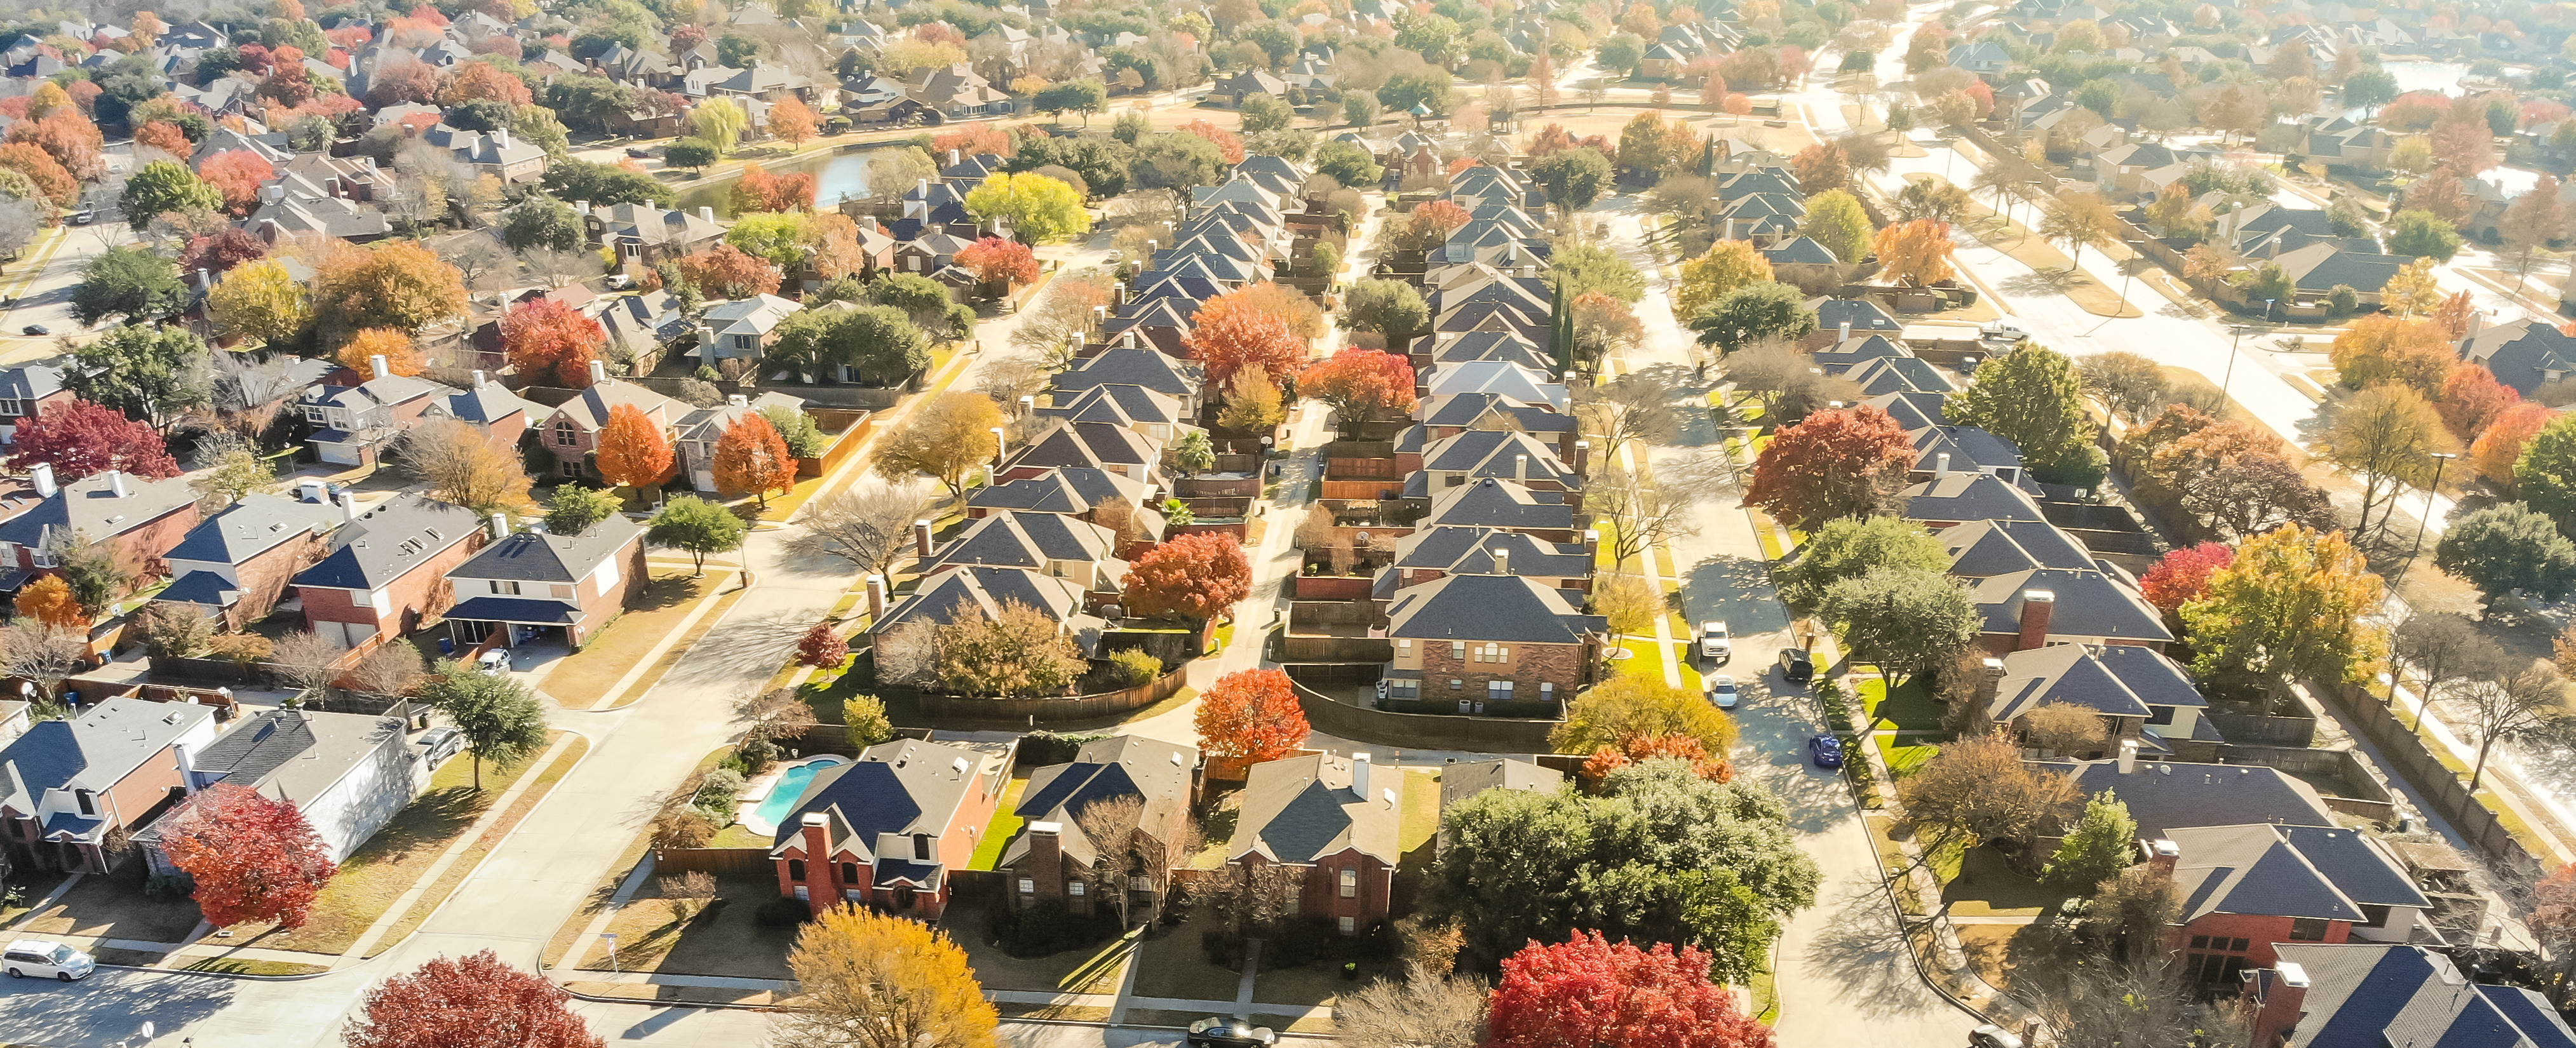
Photo by <a href="https://stock.adobe.com/contributor/205340899/trongnguyen?load_type=author&prev_url=detail" >Trong Nguyen</a> on Adobe Stock

# Phase 2 Project: *King's County Housing Data Fair Price Model*

### By Ryan Posternak

Flatiron School, Full-time Live NYC<br>
Project Presentation Date: June 24th, 2022<br>
Instructor: Joseph Mata

# Overview and Business Understanding

The housing market has been on a wild ride the past few years. According to St. Louis Fed data, the median price of a U.S. home increased from around \\$320,000 at the start of the pandemic in 2020 to over \\$425,000 as of this writing in mid-2022.

With the rise in prices and furious competition for homes, especially in hot real estate markets (geographically speaking), individual homebuyers face a daunting task in trying to obtain a fair deal on a new home. Bidding wars are common, and in the heat of the moment homebuyers may find themselves tempted to throw caution to the wind and throw down enormous sums of money. The purpose of this analysis is to provide an analytical, data-driven framework to assist homebuyers in finding a fair deal on their purchase of a new house, whether they are first-time buyers looking to start a family or retirees looking for somewhere to settle down in their golden years.

Using the model, homebuyers will be able to input the features of a home and receive an estimated "fair price" based on the model. They can then use this fair price estimate to assist in their decision-making process. This will be the predictive value of the model. Models will be judged mainly based on their R^2 values (the proportion of the variation in sale price "captured" or explained by the model) and the root mean squared error (RMSE) of the model. RMSE will be used as the error metric rather than mean squared error and mean absolute error because of interpretability in the case of the former, and because we want to penalize large prediction errors in the case of the latter. A large error in fair home price prediction could result in a costly mistake for a homebuyer, which we want to avoid.

**Also try to figure out which features are the most correlated with home price. This will be the inferential value of the model.**

This framework will be built using a dataset on U.S. home sales, described below. First we'll do some exploratory data analysis (EDA) and preprocessing to gain an understanding for the dataset and clean it. Then, a baseline linear regression model will be built to set a benchmark, using the sale price of the home as the target (dependent) variable.

Once the baseline is set, a variety of statistical and computational techniques will be used to build the most accurate and predictive model possible. Finally, we'll judge the quality of the model, and discuss recommendations, limitations, and ideas for possible further research and analysis.

<br>

# Description of the Data

This dataset contains data on over 20,000 home sales in King's County, WA, from May 2014 to May 2015. Each home sale has a unique ID and date of the transaction, along with 19 categorical and numerical features on the structure of the house and its accompanying property.

<br>

# Initial EDA and Data Cleaning

In [1]:
# numpy, pandas, matplotlib, seaborn, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
plt.style.use('seaborn')
sns.set_style('darkgrid')
%matplotlib inline

# statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

# sci-kit learn
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.feature_selection import RFECV

In [2]:
# Load up the data and preview dataframe
df = pd.read_csv('data/kc_house_data.csv')
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ...          grade sqft_above  \
0      5650     1.0        NaN  NONE  ...      7 Average       1180   
1      7242     2.0         NO  NONE  ...      7 Average       2170   
2     10000     1.0         NO  NONE  ...  6 Low Average        770   
3      5000     1.0         NO  NONE  ...      7 Average       1050   
4      8080     1.0         NO  NONE  ...         8 Good       1680   

   sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
0            0.0     1955           0.0    98178  47.5112 -122.257   
1          400.0     1951        1991.0    98125  47.7210 -122.319   
2            0.0     1933           NaN    98028  47.7379 -122.233   
3          910.0     1965           0.0    98136  47.5208 -122.393   
4            0.0     1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503  

[5 rows x 21 columns]

In [3]:
# Preview dataframe info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

> **Remarks:**
> - 15 numerical (int/float) features, six object (string) features
> - Four numerical features, 'id', 'date', 'zipcode', 'lat', and 'long', should be considered categorical descriptors
> - Three ordinal categorical features, 'view', 'condition', and 'grade', are of datatype 'object'
> - We have some missing data in the 'waterfront', 'view', and 'yr_renovated' columns
> - 'sqft_basement' is in dtype 'object'. Upon further inspection, column contains '?' values

### Description of columns (included with dataset)

**id** - Unique identifier for a house<br>
**date** - Date house was sold<br>
**price** - Sale price (prediction target)<br>
**bedrooms** - Number of bedrooms<br>
**bathrooms** - Number of bathrooms<br>
**sqft_living** - Square footage of living space in the home<br>
**sqft_lot** - Square footage of the lot<br>
**floors** - Number of floors (levels) in house<br>
**waterfront** - Whether the house is on a waterfront. Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts.<br>
**view** - Quality of view from house. Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other.<br>
**condition** - How good the overall condition of the house is. Related to maintenance of house.<br>
**grade** - Overall grade of the house. Related to the construction and design of the house.<br>
**sqft_above** - Square footage of house apart from basement<br>
**sqft_basement** - Square footage of the basement<br>
**yr_built** - Year when house was built<br>
**yr_renovated** - Year when house was renovated<br>
**zipcode** - ZIP Code used by the United States Postal Service<br>
**lat** - Latitude coordinate<br>
**long** - Longitude coordinate<br>
**sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors<br>
**sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [4]:
# Overview of basic statistics on numerical features of the dataset, excluding categorical descriptors in 
# numerical form

desc_vars = df.drop(columns=['id', 'zipcode', 'lat', 'long'])
desc_vars.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  2.159700e+04   
mean   5.402966e+05      3.373200      2.115826   2080.321850  1.509941e+04   
std    3.673681e+05      0.926299      0.768984    918.106125  4.141264e+04   
min    7.800000e+04      1.000000      0.500000    370.000000  5.200000e+02   
25%    3.220000e+05      3.000000      1.750000   1430.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.618000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068500e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    sqft_above      yr_built  yr_renovated  sqft_living15  \
count  21597.000000  21597.000000  21597.000000  17755.000000   21597.000000   
mean       1.494096   1788.596842   1970.999676     83.636778    1986.620318   
std        0.539683    827.759761     29.375234    399.946414     685.230472   
min        1.000000    370.000000   1900.000000      0.000000     399.000000   
25%        1.000000   1190.000000   1951.000000      0.000000    1490.000000   
50%        1.500000   1560.000000   1975.000000      0.000000    1840.000000   
75%        2.000000   2210.000000   1997.000000      0.000000    2360.000000   
max        3.500000   9410.000000   2015.000000   2015.000000    6210.000000   

          sqft_lot15  
count   21597.000000  
mean    12758.283512  
std     27274.441950  
min       651.000000  
25%      5100.000000  
50%      7620.000000  
75%     10083.000000  
max    871200.000000

> **Remarks:**
> - Strong degree of outliers in number of bedrooms and bathrooms, square footage of the home, and square footage of the property

### Initial Visualization of Numerical Features with Correlation Heatmap
A correlation heatmap will aid in the process of determining strongest individual feature correlations with price, which will be used to build a baseline model. Correlations between features will also be displayed, which could show potential multicollinearity issues.

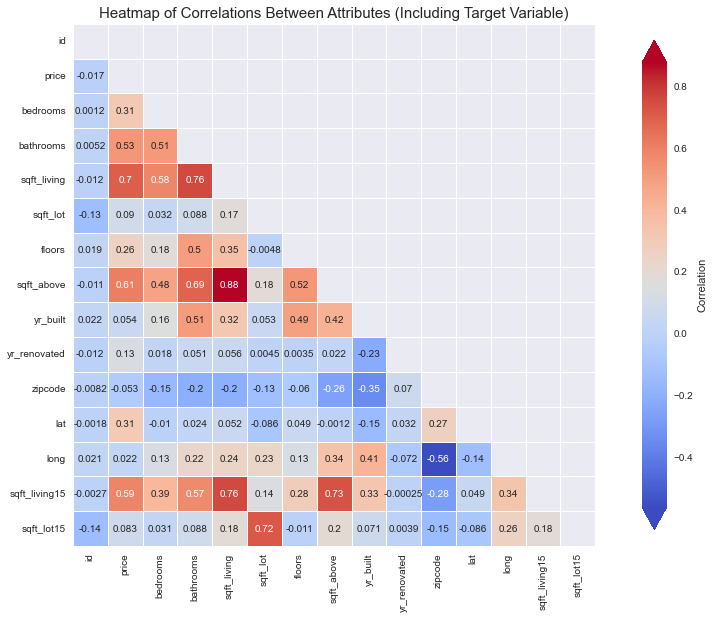

In [5]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(12, 10))

# Mask duplicate correlations and self-correlations
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=corr, annot=True, cmap='coolwarm', mask=mask, square=True, linewidths=.6, 
            cbar_kws={"label": "Correlation", "orientation": "vertical", "pad": .07, "extend": "both", "shrink": .9})

ax.set_title('Heatmap of Correlations Between Attributes (Including Target Variable)', fontsize=15);

> **Remarks:**
> - Features most strongly correlated with price include those describing square footage of the home and the property, as well as number of bathrooms (much more so than bedrooms)
>  - 'sqft_living', 'sqft_above', 'sqft_living15', 'bathrooms'
> - No strong negative correlations with price
> - Strongest correlations between features include correlations between values that relate to square footage of the home and surrounding homes, as well as square footage of the lot and surrounding lots (as one would expect). Additionally, number of bathrooms and bedrooms are both positively correlated with square footage values of the home:
>  - 'sqft_above' 'sqft_living', and 'sqft_living15' all positively correlated with each other
>  - 'bathrooms' positively correlated with the above, along with 'floors' and 'yr_built'
>  - 'sqft_lot' positively correlated with 'sqft_lot15'

## Data Cleaning and Preprocessing

Initial preprocessing includes replacing missing values ('NaN' and '?' values) so statistical analyses can be conducted on the relevant columns. Additionally, some column datatypes have been converted into float and datetime, where they were previously of type object.

**Checklist:**
- Missing values
- Non-numeric data<br>
<br>
- Transform 'waterfront' column into binary categorical feature: 0 meaning "no waterfront" and 1 meaning "has waterfront". Replace NaN (missing) values with 0.
 - Assumption: Homes with NaN 'waterfront' values have no waterfront
- Replace NaN (missing) 'yr_renovated' values with 0.0, and convert datatype to int
 - Assumption: Homes with NaN 'yr_renovated' values were never renovated
- Replace NaN (missing) 'view' values with NONE
 - Assumption: Homes with NaN 'view' values do not have a view of any of the listed landmarks 
- Replace '?' values in 'sqft_basement' with 0.0, and convert datatype to float
 - Assumption: '?' and 0.0 values in 'sqft_basement' both mean "no basement"
- Transform 'date' column into datetime format
 - Purpose: So season can be extracted from dates
- Transform ordinal features - 'view', 'condition', and 'grade' - to datatype 'category'
 - Assumption: Additive in an equidistant manner - discussed further in Model 3

In [6]:
# Create copy of dataframe to maintain integrity of original dataframe

housing_df = df.copy()

In [7]:
# Replace NaN values in 'waterfront' column, and convert into binary categorical
housing_df['waterfront'].fillna('NO', inplace=True)
housing_df['waterfront'].replace({'NO': 0, 'YES': 1}, inplace=True)

# Replace 'yr_renovated' NaN values and convert to dtype int
housing_df['yr_renovated'] = housing_df['yr_renovated'].fillna(0.0).astype(int)

# Replace 'view' NaN values
housing_df['view'].fillna('NONE', inplace=True)

# Convert 'date' column into dtype datetime
housing_df['date'] = pd.to_datetime(housing_df['date'])

# Replace '?' values in 'sqft_basement' with '0.0' and convert column into dtype float
housing_df['sqft_basement'] = housing_df['sqft_basement'].replace('?', '0.0').astype('float')

In [8]:
# Convert ordinal variables to dtype 'category'

housing_df['view'] = housing_df['view'].astype('category')
housing_df['condition'] = housing_df['condition'].astype('category')
housing_df['grade'] = housing_df['grade'].astype('category')

# Reorder categories in correct order
housing_df['view'] = housing_df['view'].cat.reorder_categories(['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'])
housing_df['condition'] = housing_df['condition'].cat.reorder_categories(['Poor', 'Fair', 'Average', 'Good', 'Very Good'])
housing_df['grade'] = housing_df['grade'].cat.reorder_categories(['3 Poor', '4 Low', '5 Fair', '6 Low Average', 
                                                            '7 Average', '8 Good', '9 Better', '10 Very Good', 
                                                            '11 Excellent', '12 Luxury', '13 Mansion'])

# Set up lists for Ordinal Encoder
ordinals = housing_df.select_dtypes('category')
view_list = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
condition_list = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
grade_list = ['3 Poor', '4 Low', '5 Fair', '6 Low Average', '7 Average', '8 Good', 
              '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']

In [9]:
# Instantiate OrdinalEncoder and fit to ordinals
ord_enc = OrdinalEncoder(categories = [view_list, condition_list, grade_list])
ord_enc.fit(ordinals)

# Transform the ordinal categorical subset
ordinals_encoded = pd.DataFrame(ord_enc.transform(ordinals), columns = ordinals.columns)
ordinals_encoded

view  condition  grade
0       0.0        2.0    4.0
1       0.0        2.0    4.0
2       0.0        2.0    3.0
3       0.0        4.0    4.0
4       0.0        2.0    5.0
...     ...        ...    ...
21592   0.0        2.0    5.0
21593   0.0        2.0    5.0
21594   0.0        2.0    4.0
21595   0.0        2.0    5.0
21596   0.0        2.0    4.0

[21597 rows x 3 columns]

In [10]:
# Replace object ordinal columns in housing_df with ordinal encoded columns
housing_df['view'] = ordinals_encoded['view']
housing_df['condition'] = ordinals_encoded['condition']
housing_df['grade'] = ordinals_encoded['grade']

In [11]:
# No missing values and properly converted datatypes - sanity check

housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     21597 non-null  int64         
 9   view           21597 non-null  float64       
 10  condition      21597 non-null  float64       
 11  grade          21597 non-null  float64       
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  float64       
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   2159

<br>

# Train/Test Splitting and Building a Baseline Model

## Train/Test Split
<br>
After initial data cleaning and preprocessing, we'll separate the data into a train/test split. At this point we're going to split all of the cleaned data - we won't worry about non-numeric data, unique identifier data, etc. for now. We will also keep the default test_size of 0.25.

In [12]:
y = housing_df['price']
X = housing_df.drop(columns='price')

# Create train/test splits, with test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")
print()
print(f"X_test is a DataFrame with {X_test.shape[0]} rows and {X_test.shape[1]} columns")
print(f"y_test is a Series with {y_test.shape[0]} values")

X_train is a DataFrame with 16197 rows and 20 columns
y_train is a Series with 16197 values

X_test is a DataFrame with 5400 rows and 20 columns
y_test is a Series with 5400 values


## Model 0: Baseline Model
Our baseline model will be a simple linear regression between price and 'sqft_living', which is the most correlated feature with price based on our heatmap above.

We'll perform five train/test splits within our X_train and y_train, then we'll display the average R-squared score of the five of them.

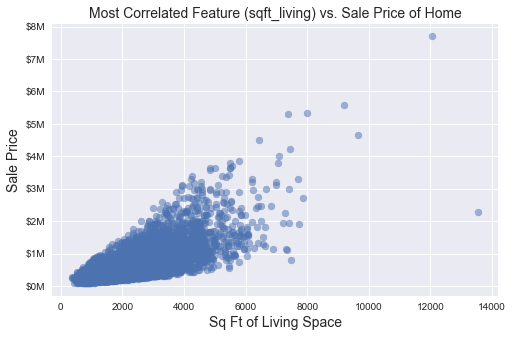

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(X_train['sqft_living'], y_train, alpha=0.5)
ax.set_title("Most Correlated Feature (sqft_living) vs. Sale Price of Home", fontsize=14)
ax.set_xlabel('Sq Ft of Living Space', fontsize=14)
ax.set_ylabel('Sale Price', fontsize=14)
ax.set_yticks(list(range(0, 9000000, 1000000)))
ax.set_yticklabels([f"${x}M" for x in range(0, 9)]);

> **Remarks:**
> - There appears to be a fairly linear relationship between 'sqft_living' and 'price'. We'll proceed with using this variable as the baseline, without further adjustments.

### Cross Validate and Score with sklearn

In [14]:
baseline_model = LinearRegression()

In [15]:
# Instantiate splitter and cross validate baseline model with n=5 splits and default test_size
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=7)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train[['sqft_living']],
    y=y_train,
    return_train_score=True,
    cv=splitter,
    scoring=['explained_variance', 'neg_root_mean_squared_error']
)

# Calculate average train and validation R^2 scores
baseline_avg_train_r2 = round(baseline_scores["train_explained_variance"].mean(), 3)
baseline_avg_validation_r2 = round(baseline_scores["test_explained_variance"].mean(), 3)

# Calculate average train and validation RMSE scores, in absolute value form
baseline_avg_train_rmse = abs(int(baseline_scores["train_neg_root_mean_squared_error"].mean()))
baseline_avg_validation_rmse = abs(int(baseline_scores["test_neg_root_mean_squared_error"].mean()))

print(f"""BASELINE MODEL STATISTICS:

Average train R^2 score:        {baseline_avg_train_r2}
Average validation R^2 score:   {baseline_avg_validation_r2}

Average train RMSE score:       {baseline_avg_train_rmse}
Average validation RMSE score:  {baseline_avg_validation_rmse}""")

BASELINE MODEL STATISTICS:

Average train R^2 score:        0.488
Average validation R^2 score:   0.497

Average train RMSE score:       261531
Average validation RMSE score:  261181


> **Remarks:**
> The top two R^2 scores represent the amount of variance in the target variable, 'price', that the model is explaining using our single predictor variable, 'sqft_living'. The train score 0.488 represents the average of the five R^2 scores on the training sets, while the validation score 0.497 represents the average of the scores on the test sets. The train RMSE score 261,531 represents the average of the five root mean squared errors on the training sets, while the validation RMSE score 261,181 represents the average of the errors on the test sets.<br>
<br>
> This is not a particularly strong model, explaining just under half of the variance on the average of the test sets. We don't lose much predictive power on the test set though, so our model is not overfit (which is to be expected given we have only one predictor variable right now).<br>
<br>
> Our root mean squared error is about $261k, which is too large to be of much use as a predictive model.

Below is a statsmodels summary table of the simple regression.

In [16]:
X = sm.add_constant(X_train['sqft_living'])
y = y_train

model = sm.OLS(endog=y,  exog=X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                 1.559e+04
Date:                Mon, 20 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:14:51   Log-Likelihood:            -2.2503e+05
No. Observations:               16197   AIC:                         4.501e+05
Df Residuals:                   16195   BIC:                         4.501e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.099e+04   5095.343     -8.044      0.000    -5.1e+04    -3.1e+04
sqft_living   279.4423      2.238    124.878      0.000     275.056     283.828
==============================================================================
Omnibus:                    10430.239   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           291279.150
Skew:                           2.656   Prob(JB):                         0.00
Kurtosis:                      23.084   Cond. No.                     5.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> **Remarks:**
> - We see a very similar R^2 score as we did using sklearn above on the training data, as expected. We can also see that both the intercept and coefficient are statistically significant with a p-value < 0.001. The coefficient of the square footage of the living space of the home is about 279, meaning that according to this model we should expect the price of a house to increase by about $279 per additional square foot of living space.

### Baseline Model Summary and Observations

***Baseline features:*** 'sqft_living'

***Baseline R^2 values:***
- Average train R^2 score:       0.488
- Average validation R^2 score:  0.497

***Baseline RMSE values:***
- Average train RMSE score:       261,531
- Average validation RMSE score:  261,181

***Observations:***
- Using only a simple linear regression with price and square feet of living space, our validated R^2 is small at 0.497.
- The RMSE of our baseline model is large at over $261k. We will need to bring this down substantially in order to make our model useful for predictive purposes.

<br>

# Model 1: Using All Numerical Features (Not Including Ordinals)

The first model iteration will incorporate the rest of the numerical features in the original dataframe, minus the five descriptor variables and the three ordinal variables that we identified earlier.

In [17]:
# Create dataframes

X_train_numeric = X_train.select_dtypes('number').drop(columns=['id', 'zipcode', 'lat', 'long', 'view', 
                                                                'condition', 'grade']).copy()

### Cross Validate and Score with sklearn

In [18]:
model_1 = LinearRegression()

In [19]:
# Cross validate and score
model_1_scores = cross_validate(
    estimator=model_1,
    X=X_train_numeric,
    y=y_train,
    return_train_score=True,
    cv=splitter,
    scoring=['explained_variance', 'neg_root_mean_squared_error']
)

# Store features used in model
model_1_features = X_train_numeric.columns

# Calculate average train and validation R^2 scores
m1_avg_train_r2 = round(model_1_scores["train_explained_variance"].mean(), 3)
m1_avg_validation_r2 = round(model_1_scores["test_explained_variance"].mean(), 3)

# Calculate average train and validation RMSE scores, in absolute value form
m1_avg_train_rmse = abs(int(model_1_scores["train_neg_root_mean_squared_error"].mean()))
m1_avg_validation_rmse = abs(int(model_1_scores["test_neg_root_mean_squared_error"].mean()))

print(f"""MODEL 1 STATISTICS:

Changes: Added all available numeric predictors, minus categorical descriptors and ordinal categorical variables

Average train R^2 score:        {m1_avg_train_r2}
Average validation R^2 score:   {m1_avg_validation_r2}

Average train RMSE score:       {m1_avg_train_rmse}
Average validation RMSE score:  {m1_avg_validation_rmse}""")

MODEL 1 STATISTICS:

Changes: Added all available numeric predictors, minus categorical descriptors and ordinal categorical variables

Average train R^2 score:        0.604
Average validation R^2 score:   0.594

Average train RMSE score:       229845
Average validation RMSE score:  234549


### Model 1 Summary and Observations

***Baseline Scores:***
- Average validation R^2 score:  0.479
- Average validation RMSE score:  263,117

***Model 1 Scores:***
- Average validation R^2 score:   0.594
- Average validation RMSE score:  234,549

***Observations:***
- Adding in all possible numerical predictors, we obtained quite a substantial improvement in our validated R^2 score, rising to 0.594 for the average of the test sets.
- The RMSE of our baseline model was reduced to about to $234k. This is an improvement on our baseline, but we still have quite a ways to go.

## Identify Possible Improvements with Histograms

Let's take a look at the histograms of our current features to see if we can identify any areas for improvement.

In [20]:
# nrows = math.ceil(len(model_1_features) / 3)

# fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, 20))

# numericals = [column for column in model_1_features]

# for feature, ax in zip(numericals, axes.flatten()):
#     ax.hist(X_train_numeric[feature], bins='auto')
#     ax.set_title(feature)
    
# fig.tight_layout()

> **Remarks:**
> - Two of our features appear to be zero-inflated: 'sqft_basement' and 'yr_renovated'. Zero-inflated predictor variables can degrade the quality of a liner regression model. Let's convert these to binary categorical form: 'has_basement' and 'renovated'. A 0 will indicate 'No' for both predictors, while a 1 will indicate 'Yes'.

<br>

# Model 2: Transform Zero-Inflated Variables

### Feature Engineering

In [21]:
# Convert 'sqft_basement' to dtype int and replace any value > 0 with 1

X_train_numeric['sqft_basement'] = X_train_numeric['sqft_basement'].astype('int')
X_train_numeric.loc[X_train_numeric['sqft_basement'] > 0, 'sqft_basement'] = 1

# Replace 'yr_renovated' values > 0 with 1
X_train_numeric.loc[X_train_numeric['yr_renovated'] > 0, 'yr_renovated'] = 1

# Update column names
X_train_numeric.rename(columns={'sqft_basement': 'has_basement', 'yr_renovated': 'renovated'}, inplace=True)

In [22]:
# Sanity check

X_train_numeric

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
6405          3       2.50         1880      4499     2.0           0   
937           3       2.50         2020      6564     1.0           0   
19076         5       4.00         4720    493534     2.0           0   
15201         2       2.00         1430      3880     1.0           0   
13083         3       2.25         2270     32112     1.0           0   
...         ...        ...          ...       ...     ...         ...   
11964         3       2.50         2230      5800     2.0           0   
21575         4       2.75         2770      3852     2.0           0   
5390          4       1.50         1530      9000     1.0           0   
860           1       0.75          380     15000     1.0           0   
15795         4       2.50         2755     11612     2.0           0   

       sqft_above  has_basement  yr_built  renovated  sqft_living15  \
6405         1880             0      1993          0           2130   
937          1310             1      1994          0           1710   
19076        3960             1      1975          0           2160   
15201        1430             0      1949          0           1430   
13083        1740             1      1980          0           2310   
...           ...           ...       ...        ...            ...   
11964        2230             0      2004          0           2230   
21575        2770             0      2014          0           1810   
5390         1530             0      1976          0           1520   
860           380             0      1963          0           1170   
15795        2755             0      2001          0           2820   

       sqft_lot15  
6405         5114  
937          5151  
19076      219542  
15201        3880  
13083       41606  
...           ...  
11964        6088  
21575        5641  
5390         8500  
860         15000  
15795       12831  

[16197 rows x 12 columns]

### Cross Validate and Score with sklearn

In [23]:
model_2 = LinearRegression()

In [24]:
# Cross validate and score
model_2_scores = cross_validate(
    estimator=model_2,
    X=X_train_numeric,
    y=y_train,
    return_train_score=True,
    cv=splitter,
    scoring=['explained_variance', 'neg_root_mean_squared_error']
)

# Store features used in model
model_2_features = X_train_numeric.columns

# Calculate average train and validation R^2 scores
m2_avg_train_r2 = round(model_2_scores["train_explained_variance"].mean(), 3)
m2_avg_validation_r2 = round(model_2_scores["test_explained_variance"].mean(), 3)

# Calculate average train and validation RMSE scores, in absolute value form
m2_avg_train_rmse = abs(int(model_2_scores["train_neg_root_mean_squared_error"].mean()))
m2_avg_validation_rmse = abs(int(model_2_scores["test_neg_root_mean_squared_error"].mean()))

print(f"""MODEL 2 STATISTICS:

Changes: Converted 'sqft_basement' and 'yr_renovated' to binary categoricals

Average train R^2 score:        {m2_avg_train_r2}
Average validation R^2 score:   {m2_avg_validation_r2}

Average train RMSE score:       {m2_avg_train_rmse}
Average validation RMSE score:  {m2_avg_validation_rmse}""")

MODEL 2 STATISTICS:

Changes: Converted 'sqft_basement' and 'yr_renovated' to binary categoricals

Average train R^2 score:        0.605
Average validation R^2 score:   0.595

Average train RMSE score:       229771
Average validation RMSE score:  234480


### Model 2 Summary and Observations

***Baseline Scores:***
- Average validation R^2 score:  0.479
- Average validation RMSE score:  263,117

***Model 1 Scores:***
- Average validation R^2 score:   0.603
- Average validation RMSE score:  230,006

***Model 2 Scores:***
- Average validation R^2 score:   0.595
- Average validation RMSE score:  234,480

***Observations:***
- So we didn't get much change at all in either our R^2 values nor our RMSE values. Both values actually worsened the slightest bit, but we can chalk that up to randomness. Since our scores didn't get any worse, and the data will be less cumbersome to work with, we'll retain these updates in our new models going forward.

<br>

# Model 3: Adding ordinal categorical variables

We still have three ordinal categorical features that we haven't included in our models yet: 'view', 'condition', and 'grade'. We converted these to ordinal interger form in preprocessing so sklearn can run them in a linear regression model. An assumption here is that each of the ordinal variables are additive in an equidistant manner — in other words, going one step from 'Average' to 'Good' in the variables is comparable to going one step from 'Good' to 'Very Good'. This seems to be a pretty safe assumption.

Additionally, the 'view' column is unique in that many houses have no view at all, while the ones that do are ranked on the quality of the view. It's more of a speculative assumption to assume going from 'NONE' to 'FAIR' in this variable is comparable to going from 'FAIR' to 'AVERAGE', from 'AVERAGE' to 'GOOD', etc., but it's an assumption we will make nevertheless.

In [25]:
# Merge dataframes

X_train_combined = pd.concat([X_train_numeric, ordinals_encoded], axis=1, join='inner', ignore_index=False)

In [26]:
# Sanity check

indexes = np.random.choice(X_train_combined.index, size=5)

housing_df.loc[indexes][['view', 'condition', 'grade']] == \
X_train_combined.loc[indexes][['view', 'condition', 'grade']]

view  condition  grade
21296  True       True   True
11407  True       True   True
13314  True       True   True
2653   True       True   True
8716   True       True   True

### Cross Validate and Score with sklearn

In [27]:
model_3 = LinearRegression()

In [28]:
# Cross validate and score
model_3_scores = cross_validate(
    estimator=model_3,
    X=X_train_combined,
    y=y_train,
    return_train_score=True,
    cv=splitter,
    scoring=['explained_variance', 'neg_root_mean_squared_error']
)

# Store features used in model
model_3_features = X_train_numeric.columns

# Calculate average train and validation R^2 scores
m3_avg_train_r2 = round(model_3_scores["train_explained_variance"].mean(), 3)
m3_avg_validation_r2 = round(model_3_scores["test_explained_variance"].mean(), 3)

# Calculate average train and validation RMSE scores, in absolute value form
m3_avg_train_rmse = abs(int(model_3_scores["train_neg_root_mean_squared_error"].mean()))
m3_avg_validation_rmse = abs(int(model_3_scores["test_neg_root_mean_squared_error"].mean()))

print(f"""MODEL 3 STATISTICS:

Changes: Converted 'sqft_basement' and 'yr_renovated' to binary categoricals

Average train R^2 score:        {m3_avg_train_r2}
Average validation R^2 score:   {m3_avg_validation_r2}

Average train RMSE score:       {m3_avg_train_rmse}
Average validation RMSE score:  {m3_avg_validation_rmse}""")

MODEL 3 STATISTICS:

Changes: Converted 'sqft_basement' and 'yr_renovated' to binary categoricals

Average train R^2 score:        0.663
Average validation R^2 score:   0.651

Average train RMSE score:       212078
Average validation RMSE score:  217713


### Model 3 Summary and Observations

*Note: From this point forward, we'll only list baseline, best model so far, and current model scores, for brevity.*

***Baseline Scores:***
- Average validation R^2 score:  0.479
- Average validation RMSE score:  263,117

***Best Model so Far - Model 1 Scores:***
- Average validation R^2 score:   0.603
- Average validation RMSE score:  230,006

***Model 3 Scores:***
- Average validation R^2 score:   0.651
- Average validation RMSE score:  217713

***Observations:***
- Adding in the three ordinal categorical variables gave us a solid bump in both scores: average validation R^2 score rose about 0.05 to 0.651, and the average validation RMSE score fell about 13k to $218k.

# Model ?: Adding 'season' Feature with OHE

In [35]:
# X_train_categoricals = X_train.select_dtypes('object')
# X_train_categoricals['view'].value_counts()

In [36]:
# # (1) Create a variable fireplace_qu_train
# # extracted from X_train
# # (double brackets due to shape expected by OHE)
# X_train_categoricals = X_train[['view', 'condition', 'grade']]

# # (2) Instantiate a OneHotEncoder with categories="auto",
# # sparse=False, and handle_unknown="ignore"
# ohe = OneHotEncoder(categories='auto', drop='first', sparse=False, handle_unknown='error')

# # (3) Fit the encoder on fireplace_qu_train
# ohe.fit(X_train_categoricals)

# # Inspect the categories of the fitted encoder
# ohe.categories_

## Identify Possible Improvements with Histograms

Let's take another look at the histograms to look for any additional improvements we can make to the numerical data.

In [37]:
# nrows = math.ceil(len(model_2_features) / 3)

# fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, 20))

# numericals = [column for column in model_2_features]

# for feature, ax in zip(numericals, axes.flatten()):
#     ax.hist(X_train_numeric[feature], bins='auto')
#     ax.set_title(feature)
    
# fig.tight_layout()

> **Remarks:**
> - Some of the variables are right-skewed due to some large outliers: 'bedrooms', 'sqft_living', 'sqft_living15', 'sqft_above', 'sqft_lot', and 'sqft_lot15'. Let's try log transforming these variables to make the distributions more normal.

<br>

# Model ?: Log Transform Right-Skewed Features

### Feature Engineering

In [38]:
# right_skewed = ['sqft_living', 'sqft_living15', 'sqft_above', 'sqft_lot', 'sqft_lot15']

# # Log transform
# X_train_numeric[right_skewed] = X_train_numeric[right_skewed].apply(np.log)

# # Update column names
# X_train_numeric.rename(columns={column: column + '_log' for column in right_skewed}, inplace=True)

In [39]:
# Sanity check

# X_train_numeric.head()

### Cross Validate and Score with sklearn

In [40]:
# model_3 = LinearRegression()